# FinBERT Sentiment Analysis for S&P 500 Stocks

This notebook implements a sentiment-based trading strategy using FinBERT to analyze financial news headlines and backtest predictive signals.

**Pipeline Overview:**
1. Environment Setup & Configuration
2. Data Loading & Filtering (S&P 500 stocks)
3. Trading Day Alignment & FinBERT Sentiment Scoring
4. Daily Aggregation & Price Data
5. Forward Returns Calculation
6. Information Coefficient (IC) Analysis
7. Decile Portfolio Backtest
8. Fama-French Factor Regression
9. Signal Optimization & Holding Period Analysis

## Research Hypothesis

**Why should news sentiment predict cross-sectional returns?**

| Mechanism | Description |
|-----------|-------------|
| **Information Diffusion** | News disseminates unevenly; early sentiment captures signals before full price adjustment |
| **Attention Effects** | Stocks with more coverage experience faster price discovery; low-coverage stocks underreact |
| **Behavioral Biases** | Anchoring causes investors to underweight new information, creating short-term predictability |

**Testable Predictions:**
1. Positive Spearman IC between sentiment and next-day returns
2. IC decays over holding periods as information gets priced in
3. Alpha survives Fama-French 3-factor risk adjustment
4. High-conviction signals (3+ headlines/day) should outperform low-conviction signals

---
## Stage 0: Environment Setup

Install required packages and configure the runtime environment.

In [6]:
pip install -q transformers torch pandas numpy tqdm pyarrow yfinance pandas_market_calendars statsmodels scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.2/211.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 9.5.0 requires toolz<1,>=0.11, but you have toolz 1.1.0 which is incompatible.


In [7]:
import os
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Market data & calendars
import yfinance as yf
import pandas_market_calendars as mcal

# ML/NLP
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Statistics
from scipy.stats import spearmanr
from scipy import stats
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt

print("All imports successful!")

All imports successful!


In [8]:
from google.colab import drive
drive.mount('/content/drive')

# Project paths
PROJECT_PATH = '/content/drive/MyDrive/sentiment_project'
os.makedirs(PROJECT_PATH, exist_ok=True)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Processing parameters
BATCH_SIZE = 32          # FinBERT batch size
CHUNK_SIZE = 5_000       # Processing chunk size
CHECKPOINT_EVERY = 20_000  # Save checkpoint frequency

print(f"Project path: {PROJECT_PATH}")
print(f"Device: {DEVICE}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project path: /content/drive/MyDrive/sentiment_project
Device: cuda
CUDA available: True
GPU: Tesla T4


In [9]:
# HELPER FUNCTIONS

def save_checkpoint(df, filename, path=PROJECT_PATH):
    """Save dataframe as parquet with confirmation."""
    filepath = os.path.join(path, filename)
    df.to_parquet(filepath, index=False)
    print(f"✓ Saved: {filename} ({len(df):,} rows)")

def load_checkpoint(filename, path=PROJECT_PATH):
    """Load parquet file with confirmation."""
    filepath = os.path.join(path, filename)
    df = pd.read_parquet(filepath)
    print(f"✓ Loaded: {filename} ({len(df):,} rows)")
    return df

def list_checkpoints(path=PROJECT_PATH):
    """List all saved parquet files."""
    files = [f for f in os.listdir(path) if f.endswith('.parquet')]
    print(f"Available checkpoints in {path}:")
    for f in sorted(files):
        size = os.path.getsize(os.path.join(path, f)) / 1e6
        print(f"  - {f} ({size:.1f} MB)")
    return files

def perf_stats(returns):
    """Calculate performance statistics for a return series."""
    return pd.Series({
        'mean_daily': returns.mean(),
        'std_daily': returns.std(),
        'sharpe': returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0,
        'total_return': (1 + returns).prod() - 1,
        'n_days': len(returns)
    })

# Stage 1: Data Loading & Filtering

**What this does:**
- Loads 1.4M news headlines from CSV (using chunks to avoid memory issues)https://www.kaggle.com/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests?select=analyst_ratings_processed.csv
- Filters for S&P 500 stocks only
- Keeps only stocks with 50+ headlines (improves signal quality)
- Saves clean dataset as parquet for faster future loading

**Output:** `analyst_ratings_final.parquet` (~330k headlines, 370 stocks)

In [25]:
# Load headlines in chunks
chunks = []
for chunk in pd.read_csv(
    '/content/drive/MyDrive/sentiment_project/analyst_ratings_processed.csv',
    usecols=['date', 'stock', 'title'],
    chunksize=100000
):
    chunks.append(chunk)
df = pd.concat(chunks, ignore_index=True)
print(f"Loaded: {len(df):,} headlines")

# Filter to S&P 500
# Add a User-Agent header to avoid 403 Forbidden error
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', storage_options={'User-Agent': 'Mozilla/5.0'})[0]
sp500_tickers = set(sp500['Symbol'].str.replace('.', '-', regex=False))
df = df[df['stock'].isin(sp500_tickers)].dropna(subset=['title'])
print(f"After S&P 500 filter: {len(df):,} headlines, {df['stock'].nunique()} stocks")


Loaded: 1,400,469 headlines
After S&P 500 filter: 328,497 headlines, 384 stocks


---
## Stage 2: Trading Day Alignment & Sentiment Extraction

**Part A:** Assign each headline to the correct trading day based on NYSE calendar.  
**Part B:** Extract sentiment scores using FinBERT.

In [26]:
# News before 4pm → affects same day
# News after 4pm → affects next trading day

df = df.copy()

# Convert to datetime with UTC
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
df = df.dropna(subset=['date'])

# Convert to US/Eastern timezone
df['date'] = df['date'].dt.tz_convert('US/Eastern')
df['hour'] = df['date'].dt.hour + df['date'].dt.minute / 60

# Get NYSE trading calendar
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule(
    start_date=df['date'].min().date(),
    end_date=df['date'].max().date()
)
trading_days = schedule.index.tz_localize('US/Eastern')

def assign_trading_day(ts):
    """Assign headline to trading day based on publication time."""
    day = ts.normalize()
    if ts.hour < 16:
        return day
    else:
        idx = trading_days.searchsorted(day)
        return trading_days[min(idx + 1, len(trading_days) - 1)]

df['trading_date'] = df['date'].apply(assign_trading_day)

print(f"Processed {len(df):,} rows")
print(df[['date', 'hour', 'trading_date']].head())

Processed 328,497 rows
                       date       hour              trading_date
0 2020-06-05 10:30:00-04:00  10.500000 2020-06-05 00:00:00-04:00
1 2020-06-03 10:45:00-04:00  10.750000 2020-06-03 00:00:00-04:00
2 2020-05-26 04:30:00-04:00   4.500000 2020-05-26 00:00:00-04:00
3 2020-05-22 12:45:00-04:00  12.750000 2020-05-22 00:00:00-04:00
4 2020-05-22 11:38:00-04:00  11.633333 2020-05-22 00:00:00-04:00


In [ ]:
# Load pre-computed sentiment (skip FinBERT if already processed)
try:
    df = load_checkpoint('sentiment_final.parquet')
except:
    print("Processing sentiment with FinBERT...")
    all_sentiments = []
    for start in tqdm(range(0, len(df), CHUNK_SIZE)):
        chunk_titles = df['title'].iloc[start:start+CHUNK_SIZE].tolist()
        all_sentiments.extend(get_sentiment_batch(chunk_titles, BATCH_SIZE))
    df['sentiment'] = all_sentiments
    save_checkpoint(df, 'sentiment_final.parquet')


In [28]:
# Score = P(positive) - P(negative), range [-1, +1]

# Load FinBERT model
MODEL_NAME = 'ProsusAI/finbert'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(DEVICE)
model.eval()

print(f"Using device: {DEVICE}")
print(f"Label mapping: {model.config.id2label}")

def get_sentiment_batch(texts, batch_size=BATCH_SIZE):
    """Calculate sentiment scores for a batch of texts."""
    scores = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            return_tensors='pt',
            max_length=128
        ).to(DEVICE)

        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
        # FinBERT: 0=positive, 1=negative, 2=neutral
        score = probs[:, 0] - probs[:, 1]
        scores.extend(score.tolist())

    return scores

# Test with example headlines
test_headlines = [
    "Apple beats earnings expectations and raises guidance",
    "Tesla faces regulatory investigation over safety concerns",
    "Company reports flat revenue amid macro uncertainty"
]
test_scores = get_sentiment_batch(test_headlines)
print("\nTest results:")
for headline, score in zip(test_headlines, test_scores):
    print(f"  {score:+.3f} | {headline}")

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Using device: cuda
Label mapping: {0: 'positive', 1: 'negative', 2: 'neutral'}

Test results:
  +0.906 | Apple beats earnings expectations and raises guidance
  -0.920 | Tesla faces regulatory investigation over safety concerns
  -0.954 | Company reports flat revenue amid macro uncertainty


In [60]:
# ==============================================================================
# PROCESS ALL HEADLINES
# ==============================================================================
# Runtime: ~15-30 min on GPU for 330k headlines

all_sentiments = []

for start in tqdm(range(0, len(df), CHUNK_SIZE)):
    end = min(start + CHUNK_SIZE, len(df))
    chunk_titles = df['title'].iloc[start:end].tolist()

    chunk_sentiment = get_sentiment_batch(chunk_titles, batch_size=BATCH_SIZE)
    all_sentiments.extend(chunk_sentiment)

    # Save checkpoint
    if (start + CHUNK_SIZE) % CHECKPOINT_EVERY == 0:
        print(f"✓ Checkpoint saved at {start + CHUNK_SIZE}")
        df_temp = df.iloc[:len(all_sentiments)].copy()
        df_temp['sentiment'] = all_sentiments
        save_checkpoint(df_temp, f'sentiment_checkpoint_{start + CHUNK_SIZE}.parquet')

# Add sentiment to dataframe
df['sentiment'] = all_sentiments

# Save final results
save_checkpoint(df, 'sentiment_final.parquet')
print("✓ Sentiment extraction complete!")

  5%|▍         | 3/66 [00:41<14:10, 13.50s/it]

✓ Checkpoint saved at 20000


  6%|▌         | 4/66 [00:55<14:02, 13.58s/it]

✓ Saved: sentiment_checkpoint_20000.parquet (20,000 rows)


 11%|█         | 7/66 [01:32<12:35, 12.81s/it]

✓ Checkpoint saved at 40000


 12%|█▏        | 8/66 [01:45<12:32, 12.98s/it]

✓ Saved: sentiment_checkpoint_40000.parquet (40,000 rows)


 17%|█▋        | 11/66 [02:24<11:46, 12.85s/it]

✓ Checkpoint saved at 60000


 18%|█▊        | 12/66 [02:38<11:48, 13.12s/it]

✓ Saved: sentiment_checkpoint_60000.parquet (60,000 rows)


 23%|██▎       | 15/66 [03:16<11:05, 13.04s/it]

✓ Checkpoint saved at 80000


 24%|██▍       | 16/66 [03:30<11:05, 13.30s/it]

✓ Saved: sentiment_checkpoint_80000.parquet (80,000 rows)


 29%|██▉       | 19/66 [04:08<10:05, 12.88s/it]

✓ Checkpoint saved at 100000


 30%|███       | 20/66 [04:21<09:52, 12.88s/it]

✓ Saved: sentiment_checkpoint_100000.parquet (100,000 rows)


 35%|███▍      | 23/66 [05:00<09:18, 12.99s/it]

✓ Checkpoint saved at 120000


 36%|███▋      | 24/66 [05:14<09:12, 13.15s/it]

✓ Saved: sentiment_checkpoint_120000.parquet (120,000 rows)


 41%|████      | 27/66 [05:51<08:14, 12.68s/it]

✓ Checkpoint saved at 140000


 42%|████▏     | 28/66 [06:05<08:16, 13.07s/it]

✓ Saved: sentiment_checkpoint_140000.parquet (140,000 rows)


 47%|████▋     | 31/66 [06:42<07:23, 12.68s/it]

✓ Checkpoint saved at 160000


 48%|████▊     | 32/66 [06:57<07:34, 13.37s/it]

✓ Saved: sentiment_checkpoint_160000.parquet (160,000 rows)


 53%|█████▎    | 35/66 [07:34<06:34, 12.73s/it]

✓ Checkpoint saved at 180000


 55%|█████▍    | 36/66 [07:47<06:26, 12.88s/it]

✓ Saved: sentiment_checkpoint_180000.parquet (180,000 rows)


 59%|█████▉    | 39/66 [08:25<05:41, 12.65s/it]

✓ Checkpoint saved at 200000


 61%|██████    | 40/66 [08:39<05:38, 13.03s/it]

✓ Saved: sentiment_checkpoint_200000.parquet (200,000 rows)


 65%|██████▌   | 43/66 [09:17<04:55, 12.86s/it]

✓ Checkpoint saved at 220000


 67%|██████▋   | 44/66 [09:31<04:51, 13.27s/it]

✓ Saved: sentiment_checkpoint_220000.parquet (220,000 rows)


 71%|███████   | 47/66 [10:09<04:07, 13.03s/it]

✓ Checkpoint saved at 240000


 73%|███████▎  | 48/66 [10:23<03:58, 13.25s/it]

✓ Saved: sentiment_checkpoint_240000.parquet (240,000 rows)


 77%|███████▋  | 51/66 [11:02<03:16, 13.13s/it]

✓ Checkpoint saved at 260000


 79%|███████▉  | 52/66 [11:16<03:07, 13.40s/it]

✓ Saved: sentiment_checkpoint_260000.parquet (260,000 rows)


 83%|████████▎ | 55/66 [11:56<02:27, 13.40s/it]

✓ Checkpoint saved at 280000


 85%|████████▍ | 56/66 [12:12<02:20, 14.08s/it]

✓ Saved: sentiment_checkpoint_280000.parquet (280,000 rows)


 89%|████████▉ | 59/66 [12:51<01:34, 13.55s/it]

✓ Checkpoint saved at 300000


 91%|█████████ | 60/66 [13:06<01:23, 13.87s/it]

✓ Saved: sentiment_checkpoint_300000.parquet (300,000 rows)


 95%|█████████▌| 63/66 [13:44<00:39, 13.12s/it]

✓ Checkpoint saved at 320000


 97%|█████████▋| 64/66 [13:59<00:27, 13.57s/it]

✓ Saved: sentiment_checkpoint_320000.parquet (320,000 rows)


100%|██████████| 66/66 [14:21<00:00, 13.05s/it]


✓ Saved: sentiment_final.parquet (328,497 rows)
✓ Sentiment extraction complete!


In [29]:
df = load_checkpoint('sentiment_final.parquet')

✓ Loaded: sentiment_final.parquet (328,497 rows)


---
## Stage 3: Daily Aggregation & Price Data

Aggregate sentiment to daily level and download stock prices.

In [30]:
# AGGREGATE TO DAILY SENTIMENT

daily_sent = (
    df.groupby(['stock', 'trading_date'])
    .agg(
        daily_sentiment=('sentiment', 'mean'),
        news_count=('sentiment', 'count')
    )
    .reset_index()
)

print(f"Daily sentiment: {len(daily_sent):,} stock-days")
print(f"Unique stocks: {daily_sent['stock'].nunique()}")
print(daily_sent.head())

save_checkpoint(daily_sent, 'daily_sentiment.parquet')

Daily sentiment: 169,637 stock-days
Unique stocks: 384
  stock              trading_date  daily_sentiment  news_count
0     A 2009-04-29 00:00:00-04:00         0.110148           1
1     A 2009-06-02 00:00:00-04:00         0.343592           1
2     A 2009-07-14 00:00:00-04:00         0.494665           1
3     A 2009-07-31 00:00:00-04:00         0.038904           1
4     A 2009-08-04 00:00:00-04:00         0.025231           1
✓ Saved: daily_sentiment.parquet (169,637 rows)


In [31]:
# ==============================================================================
# DOWNLOAD STOCK PRICES
# ==============================================================================

stocks = daily_sent['stock'].unique().tolist()
start_date = daily_sent['trading_date'].min()
end_date = daily_sent['trading_date'].max()

print(f"Downloading prices for {len(stocks)} stocks")
print(f"Date range: {start_date} to {end_date}")

prices = yf.download(
    tickers=stocks,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=True
)

# Reshape to long format
if isinstance(prices.columns, pd.MultiIndex):
    prices_long = (
        prices['Close']
        .stack()
        .reset_index()
        .rename(columns={'Date': 'trading_date', 'level_1': 'stock', 0: 'close'})
    )
else:
    prices_long = prices.reset_index()
    prices_long.columns = ['trading_date', 'close']
    prices_long['stock'] = stocks[0]

# Rename columns if needed
if 'Ticker' in prices_long.columns:
    prices_long = prices_long.rename(columns={'Ticker': 'stock'})

print(f"\nPrices shape: {prices_long.shape}")
print(prices_long.head())

save_checkpoint(prices_long, 'prices_raw.parquet')

Date range: 2009-04-29 00:00:00-04:00 to 2020-06-11 00:00:00-04:00


[*********************100%***********************]  384 of 384 completed
ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['EXE', 'SNDK', 'Q', 'APP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2009-04-29 00:00:00-04:00 -> 2020-06-11 00:00:00-04:00) (Yahoo error = "Data doesn\'t exist for startDate = 1240977600, endDate = 1591848000")')



Prices shape: (1029912, 3)
  trading_date stock      close
0   2009-04-29     A  11.437927
1   2009-04-29  AAPL   3.753078
2   2009-04-29  ACGL   6.339324
3   2009-04-29   ACN  21.713959
4   2009-04-29  ADBE  26.750000
✓ Saved: prices_raw.parquet (1,029,912 rows)


---
## Stage 4: Calculate Forward Returns & Merge

Calculate forward returns and merge with sentiment data.

In [32]:
prices_long = load_checkpoint('prices_raw.parquet')
# CALCULATE FORWARD RETURNS
prices_long = prices_long.sort_values(['stock', 'trading_date'])

# Calculate returns for various holding periods
for days in [1, 2, 3, 5, 10]:
    prices_long[f'return_{days}d'] = (
        prices_long.groupby('stock')['close']
        .pct_change(days)
        .shift(-days)  # Forward looking
    )

print("Returns calculated:")
print(prices_long[[c for c in prices_long.columns if 'return' in c]].describe())

save_checkpoint(prices_long, 'prices_with_returns.parquet')

✓ Loaded: prices_raw.parquet (1,029,912 rows)
Returns calculated:
          return_1d     return_2d     return_3d     return_5d    return_10d
count  1.029532e+06  1.029152e+06  1.028772e+06  1.028012e+06  1.026112e+06
mean   8.059992e-04  1.603061e-03  2.422716e-03  3.986125e-03  7.749424e-03
std    1.970320e-02  2.733263e-02  3.368628e-02  4.298304e-02  5.864123e-02
min   -5.290738e-01 -6.071632e-01 -6.209935e-01 -6.726643e-01 -8.607185e-01
25%   -7.601041e-03 -1.048257e-02 -1.269439e-02 -1.581948e-02 -2.071494e-02
50%    8.150952e-04  1.761007e-03  2.552445e-03  4.183348e-03  8.064191e-03
75%    9.252797e-03  1.383872e-02  1.756568e-02  2.383615e-02  3.637824e-02
max    7.459326e-01  9.695652e-01  1.007397e+00  1.205194e+00  1.207693e+00
✓ Saved: prices_with_returns.parquet (1,029,912 rows)


In [33]:
# MERGE SENTIMENT WITH RETURNS

# Ensure date formats match
daily_sent['trading_date'] = pd.to_datetime(daily_sent['trading_date']).dt.tz_localize(None)
prices_long['trading_date'] = pd.to_datetime(prices_long['trading_date']).dt.tz_localize(None)

# Merge
data = pd.merge(
    daily_sent,
    prices_long,
    on=['stock', 'trading_date'],
    how='inner'
)

print(f"Merged data: {len(data):,} rows")
print(f"Date range: {data['trading_date'].min()} to {data['trading_date'].max()}")
print(data.head())

save_checkpoint(data, 'sentiment_with_returns.parquet')

Merged data: 161,677 rows
Date range: 2009-04-29 00:00:00 to 2020-06-10 00:00:00
  stock trading_date  daily_sentiment  news_count      close  return_1d  \
0     A   2009-04-29         0.110148           1  11.437927   0.012756   
1     A   2009-06-02         0.343592           1  12.402186  -0.011253   
2     A   2009-07-14         0.494665           1  12.364127   0.054900   
3     A   2009-07-31         0.038904           1  14.730376   0.031438   
4     A   2009-08-04         0.025231           1  15.333036  -0.026479   

   return_2d  return_3d  return_5d  return_10d  
0   0.043261   0.077094   0.066556    0.001109  
1   0.025064   0.017903   0.008696   -0.050128  
2   0.068753   0.075423   0.102103    0.194972  
3   0.040913   0.013350   0.021964    0.035314  
4  -0.037236  -0.018204  -0.011585    0.051303  
✓ Saved: sentiment_with_returns.parquet (161,677 rows)


---
## Stage 5: Information Coefficient (IC) Analysis

The Information Coefficient measures the correlation between our signal (sentiment) and forward returns. A positive IC indicates predictive power.

**Methodology**: Daily cross-sectional Spearman rank correlation between sentiment and next-day returns.

In [39]:
# INFORMATION COEFFICIENT ANALYSIS

def daily_ic(df, min_obs=5):
    """Calculate Spearman correlation for one day."""
    df = df[['daily_sentiment', 'return_1d']].dropna()

    if len(df) < min_obs or df['daily_sentiment'].nunique() <= 1:
        return np.nan

    ic, _ = spearmanr(df['daily_sentiment'], df['return_1d'])
    return ic

# Calculate IC for each trading day
ic_series = (
    data
    .groupby('trading_date', group_keys=False)
    .apply(daily_ic, include_groups=False)
    .dropna()
)

print("=" * 60)
print("INFORMATION COEFFICIENT ANALYSIS")
print("=" * 60)
print(f"IC days:    {len(ic_series):,}")
print(f"Mean IC:    {ic_series.mean():.4f}")
print(f"IC Std:     {ic_series.std():.4f}")
print(f"IC > 0:     {(ic_series > 0).sum()} days ({(ic_series > 0).mean():.1%})")
print(f"IC < 0:     {(ic_series < 0).sum()} days ({(ic_series < 0).mean():.1%})")

INFORMATION COEFFICIENT ANALYSIS
IC days:    2,720
Mean IC:    0.0071
IC Std:     0.1629
IC > 0:     1425 days (52.4%)
IC < 0:     1293 days (47.5%)


### IC Interpretation

| Metric | Value | Assessment |
|--------|-------|------------|
| Mean IC | 0.0071 | Positive but weak - typical for sentiment signals |
| Hit Rate | 52.4% | Slightly better than random |
| t-statistic | 2.28 | Statistically significant (p < 0.05) |

**Conclusion**: The signal exists but is weak. An IC of 0.007 is common for fundamental signals; profitability depends on implementation efficiency.


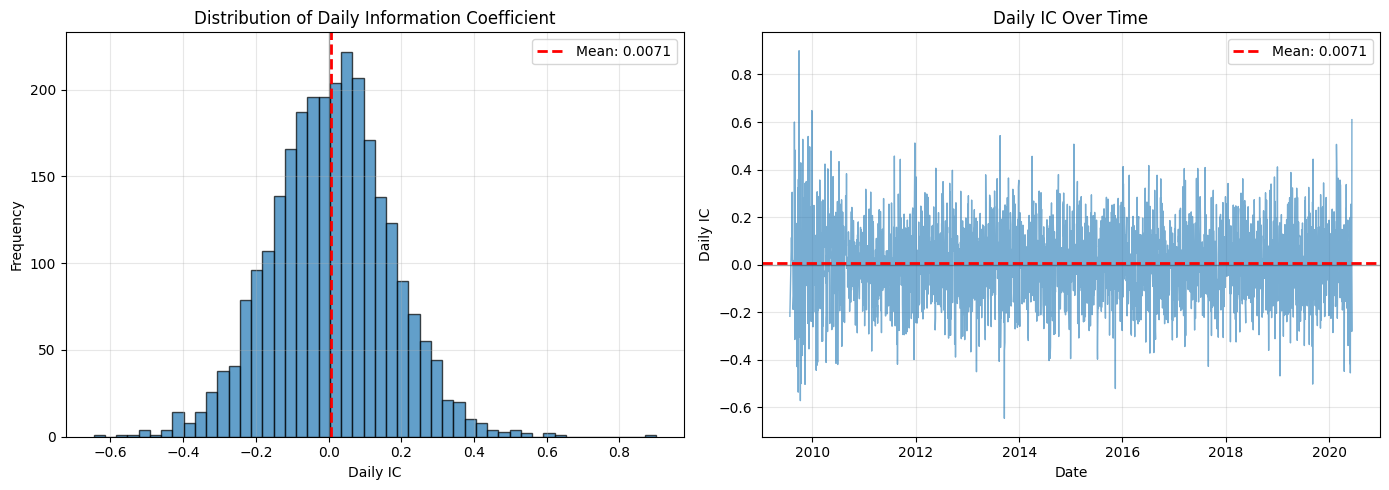

In [40]:
# VISUALIZE IC DISTRIBUTION

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(ic_series, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(ic_series.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {ic_series.mean():.4f}')
axes[0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
axes[0].set_xlabel('Daily IC')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Daily Information Coefficient')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series
axes[1].plot(ic_series.index, ic_series.values, linewidth=1, alpha=0.6)
axes[1].axhline(ic_series.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {ic_series.mean():.4f}')
axes[1].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Daily IC')
axes[1].set_title('Daily IC Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_PATH, 'ic_analysis.png'), dpi=150)
plt.show()

IC Decay by Holding Period:
------------------------------
   1-day: 0.0071
   2-day: 0.0053
   3-day: 0.0042
   5-day: 0.0041
  10-day: 0.0030


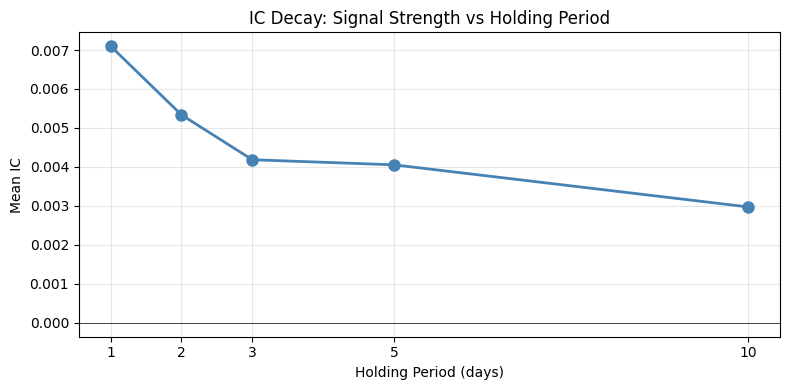

In [65]:
# IC DECAY ANALYSIS
print("IC Decay by Holding Period:")
print("-" * 30)

# Ensure 'data' is loaded as a DataFrame
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import os

# Assuming PROJECT_PATH and load_checkpoint are defined in earlier cells
# If not, they would need to be re-defined here or ensure their cells are run.
PROJECT_PATH = '/content/drive/MyDrive/sentiment_project'
def load_checkpoint(filename, path=PROJECT_PATH):
    filepath = os.path.join(path, filename)
    df = pd.read_parquet(filepath)
    # print(f"✓ Loaded: {filename} ({len(df):,} rows)") # Suppress print during fix
    return df

data = load_checkpoint('sentiment_with_returns.parquet')

ic_decay = {}
for h in [1, 2, 3, 5, 10]:
    ic = data.groupby('trading_date').apply(
        lambda g: spearmanr(g['daily_sentiment'], g[f'return_{h}d'])[0]
        if len(g.dropna(subset=['daily_sentiment', f'return_{h}d'])) >= 5 else np.nan,
        include_groups=False
    ).dropna()
    ic_decay[h] = ic.mean()
    print(f"  {h:2d}-day: {ic.mean():.4f}")

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(ic_decay.keys()), list(ic_decay.values()), 'o-', linewidth=2, markersize=8, color='steelblue')
ax.set_xlabel('Holding Period (days)')
ax.set_ylabel('Mean IC')
ax.set_title('IC Decay: Signal Strength vs Holding Period')
ax.set_xticks(list(ic_decay.keys()))
ax.axhline(0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Stage 6: Decile Portfolio Backtest

Rank stocks into deciles by sentiment each day. If sentiment is predictive, D10 (high sentiment) should outperform D1 (low sentiment).

In [19]:
def assign_deciles(df, n=10):
    """Assign stocks to deciles based on sentiment ranking."""
    df = df.copy()
    df['sentiment_rank'] = df['daily_sentiment'].rank(method='first')
    df['decile'] = pd.qcut(
        df['sentiment_rank'],
        q=n,
        labels=False,
        duplicates='drop'
    ) + 1  # deciles 1-10
    return df

data_decile = (
    data
    .groupby('trading_date') # Remove group_keys=False as it's often misunderstood with apply
    .apply(assign_deciles, include_groups=False)
    .reset_index(level='trading_date', drop=False) # Convert 'trading_date' from index level back to a column
    .dropna(subset=['decile'])
)
data_decile['decile'] = data_decile['decile'].astype(int)

print(data_decile[['trading_date', 'stock', 'daily_sentiment', 'decile']].head(10))

save_checkpoint(data_decile, 'data_with_deciles.parquet')

       trading_date stock  daily_sentiment  decile
1        2009-06-02     A         0.343592       1
41639    2009-06-02    DD         0.343592      10
37525    2009-07-21   CSX         0.033979      10
41643    2009-07-21    DD         0.020130       1
16517    2009-07-27    BG         0.017906       4
26016    2009-07-27  CDNS         0.489329       7
30113    2009-07-27   CME         0.787463       9
33083    2009-07-27   COF        -0.030478       1
41644    2009-07-27    DD         0.017906       3
104401   2009-07-27   MRK        -0.009894       2
✓ Saved: data_with_deciles.parquet (161,666 rows)


In [41]:
# CALCULATE DECILE RETURNS

decile_returns = (
    data_decile
    .groupby(['trading_date', 'decile'])['return_1d']
    .mean()
    .reset_index()
)

decile_pivot = decile_returns.pivot(
    index='trading_date',
    columns='decile',
    values='return_1d'
)

# Long-short portfolio: Long D10 (high sentiment), Short D1 (low sentiment)
decile_pivot['long_short'] = decile_pivot[10] - decile_pivot[1]

print("Decile Performance Statistics:")
print(decile_pivot.apply(perf_stats).round(4))

save_checkpoint(decile_pivot.reset_index(), 'long_short_returns.parquet')

Decile Performance Statistics:
decile                1          2          3          4          5  \
mean_daily       0.0002     0.0009     0.0008     0.0011     0.0005   
std_daily        0.0151     0.0154     0.0155     0.0149     0.0138   
sharpe           0.2318     0.9011     0.7974     1.1195     0.5180   
total_return     0.3335     6.7416     4.9350    11.7976     1.6249   
n_days        2732.0000  2732.0000  2732.0000  2732.0000  2732.0000   

decile                6          7          8          9         10  \
mean_daily       0.0007     0.0009     0.0005     0.0007     0.0008   
std_daily        0.0142     0.0139     0.0133     0.0134     0.0136   
sharpe           0.7863     1.0653     0.6397     0.8347     0.9399   
total_return     4.1050     8.6245     2.3709     4.2726     6.0104   
n_days        2732.0000  2732.0000  2732.0000  2732.0000  2732.0000   

decile        long_short  
mean_daily        0.0006  
std_daily         0.0109  
sharpe            0.8503  
total_r

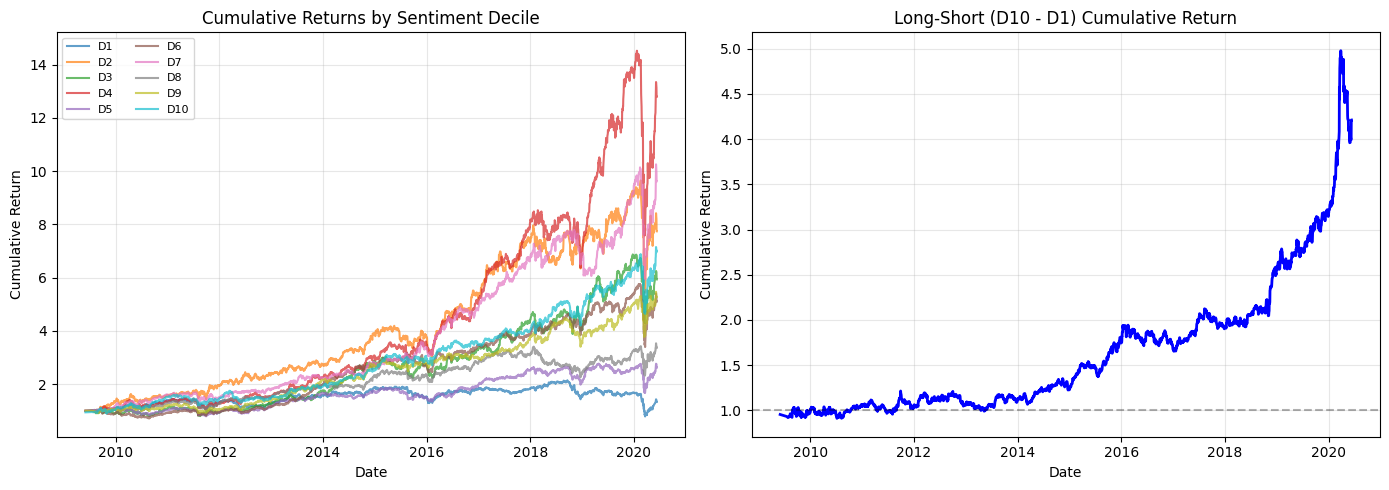

In [42]:
# VISUALIZE CUMULATIVE RETURNS

cum_returns = (1 + decile_pivot.fillna(0)).cumprod()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# All deciles
for col in range(1, 11):
    axes[0].plot(cum_returns.index, cum_returns[col], label=f'D{col}', alpha=0.7)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Cumulative Return')
axes[0].set_title('Cumulative Returns by Sentiment Decile')
axes[0].legend(ncol=2, fontsize=8)
axes[0].grid(True, alpha=0.3)

# Long-short
axes[1].plot(cum_returns.index, cum_returns['long_short'], color='blue', linewidth=2)
axes[1].axhline(1, color='black', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Return')
axes[1].set_title('Long-Short (D10 - D1) Cumulative Return')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_PATH, 'decile_returns.png'), dpi=150)
plt.show()

---
## Stage 7: Fama-French 3-Factor Regression

Test whether sentiment alpha survives after controlling for market, size (SMB), and value (HML) factors.

**Model**: $R_{LS} = \alpha + \beta_1 MKT + \beta_2 SMB + \beta_3 HML + \epsilon$

In [103]:
# Download FF factors
ff_url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip'
ff = pd.read_csv(ff_url, skiprows=3)
ff.columns = ['date', 'Mkt-RF', 'SMB', 'HML', 'RF']
# Filter out non-date rows (e.g., copyright notice at the end of the file)
ff = ff[ff['date'].str.match(r'^\d{8}$', na=False)]
ff['date'] = pd.to_datetime(ff['date'], format='%Y%m%d')
ff[['Mkt-RF', 'SMB', 'HML', 'RF']] = ff[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100

# Merge and regress
ls_returns = decile_pivot[['long_short']].reset_index()
ls_returns.columns = ['trading_date', 'ls_return']
merged = pd.merge(ls_returns, ff, left_on='trading_date', right_on='date').dropna()
merged['excess_return'] = merged['ls_return'] - merged['RF']

X = sm.add_constant(merged[['Mkt-RF', 'SMB', 'HML']])
model = sm.OLS(merged['excess_return'], X).fit()
print(model.summary())

print(f"\n{'='*50}")
print(f"Daily Alpha: {model.params['const']:.4f} ({model.params['const']*252:.2%} annualized)")
print(f"Alpha t-stat: {model.tvalues['const']:.2f} (p={model.pvalues['const']:.4f})")
print(f"{'='*50}")

                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.389
Date:                Wed, 21 Jan 2026   Prob (F-statistic):              0.244
Time:                        08:31:33   Log-Likelihood:                 8458.6
No. Observations:                2731   AIC:                        -1.691e+04
Df Residuals:                    2727   BIC:                        -1.689e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.732      0.0

### Risk-Adjusted Alpha Interpretation

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Daily Alpha | 0.0006 | ~15% annualized gross alpha |
| t-statistic | 2.73 | Significant at 1% level |
| Market Beta | -0.001 | Strategy is market-neutral ✓ |
| SMB Beta | 0.062 | Slight small-cap tilt |
| HML Beta | 0.041 | Minimal value exposure |

**Conclusion**: Alpha survives Fama-French controls. The sentiment signal is not simply a proxy for market, size, or value factors.


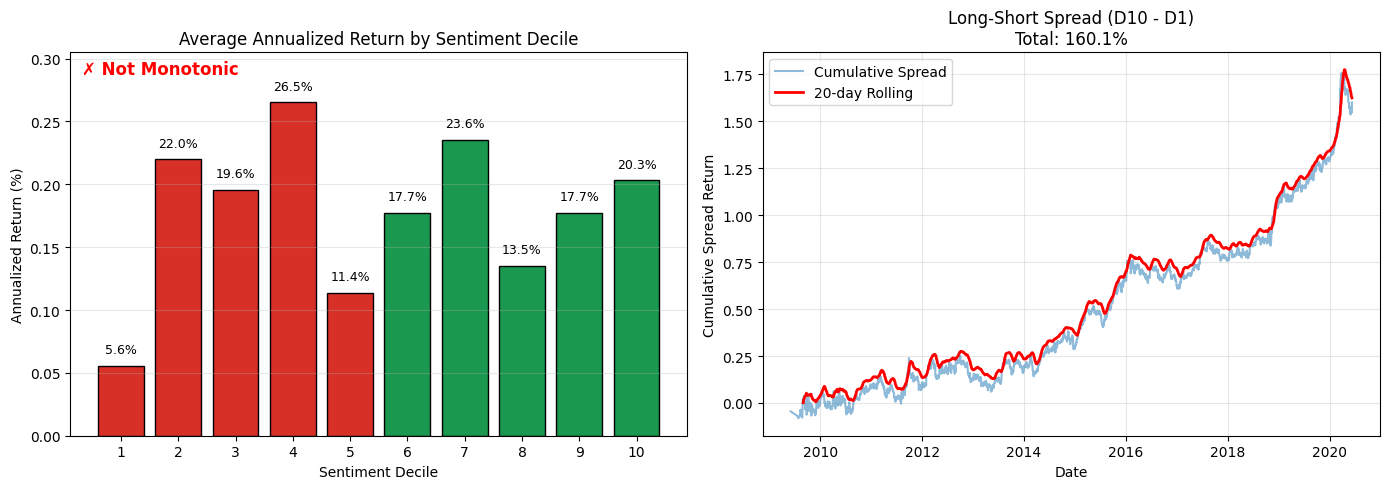


MONOTONICITY CHECK
Decile     Ann. Return     Monotonic?
-----------------------------------
D1         +0.06%         ✓
D2         +0.22%         ✓
D3         +0.20%         ✗
D4         +0.27%         ✓
D5         +0.11%         ✗
D6         +0.18%         ✓
D7         +0.24%         ✓
D8         +0.14%         ✗
D9         +0.18%         ✓
D10        +0.20%         ✓
-----------------------------------
Spread (D10-D1): 0.15%


In [43]:
# ==============================================================================
# MONOTONICITY CHECK: AVERAGE RETURNS BY DECILE
# ==============================================================================

# Calculate mean returns per decile
mean_returns_by_decile = decile_pivot.drop(columns=['long_short']).mean() * 252  # Annualized

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of mean returns by decile
colors = ['#d73027' if i < 5 else '#1a9850' for i in range(10)]
axes[0].bar(range(1, 11), mean_returns_by_decile.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Sentiment Decile')
axes[0].set_ylabel('Annualized Return (%)')
axes[0].set_title('Average Annualized Return by Sentiment Decile')
axes[0].set_xticks(range(1, 11))
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[0].grid(True, alpha=0.3, axis='y')

# Add values on bars (inside the bars or adjust ylim)
axes[0].set_ylim(0, max(mean_returns_by_decile.values) * 1.15)  # Add 15% headroom
for i, v in enumerate(mean_returns_by_decile.values):
    axes[0].text(i + 1, v + 0.01, f'{v*100:.1f}%', ha='center', fontsize=9)

# Check monotonicity
is_monotonic = all(mean_returns_by_decile.iloc[i] <= mean_returns_by_decile.iloc[i+1]
                   for i in range(len(mean_returns_by_decile)-1))
monotonic_text = "✓ Monotonic" if is_monotonic else "✗ Not Monotonic"
axes[0].text(0.02, 0.98, monotonic_text, transform=axes[0].transAxes,
             fontsize=12, verticalalignment='top',
             color='green' if is_monotonic else 'red', fontweight='bold')

# Spread (D10 - D1) over time with rolling average
spread = decile_pivot['long_short']
spread_rolling = spread.rolling(20).mean()
axes[1].plot(spread.index, spread.cumsum(), alpha=0.5, label='Cumulative Spread')
axes[1].plot(spread_rolling.index, spread_rolling.cumsum(), color='red', linewidth=2, label='20-day Rolling')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Spread Return')
axes[1].set_title(f'Long-Short Spread (D10 - D1)\nTotal: {spread.sum()*100:.1f}%')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_PATH, 'monotonicity_check.png'), dpi=150)
plt.show()

# Print monotonicity table
print("\n" + "=" * 60)
print("MONOTONICITY CHECK")
print("=" * 60)
print(f"{'Decile':<10} {'Ann. Return':<15} {'Monotonic?':<10}")
print("-" * 35)
for i, ret in enumerate(mean_returns_by_decile.values, 1):
    check = "✓" if i == 1 or ret >= mean_returns_by_decile.iloc[i-2] else "✗"
    print(f"D{i:<9} {ret:>+.2f}%{'':<8} {check}")
print("-" * 35)
print(f"Spread (D10-D1): {(mean_returns_by_decile.iloc[-1] - mean_returns_by_decile.iloc[0]):.2f}%")

---
## Stage 8: Signal Optimization & Holding Period Analysis

Evaluate signal decay and the impact of trading costs on realized returns.

**Key Question**: At what rebalancing frequency does the signal remain profitable after costs?

In [44]:
# IC Decay
print("IC Decay by Horizon:")
for h in [1, 2, 3, 5, 10]:
    ic = data.groupby('trading_date').apply(
        lambda g: spearmanr(g['daily_sentiment'], g[f'return_{h}d'])[0]
        if len(g.dropna(subset=['daily_sentiment', f'return_{h}d'])) >= 5 else np.nan,
        include_groups=False
    ).dropna().mean()
    print(f"  {h:2d}-day: {ic:.4f}")

# Holding Period Backtest with Transaction Costs
print("\nHolding Period Backtest (10bps per trade):")
results = []
for holding in [1, 2, 3, 5, 10]:
    ret_col = f'return_{holding}d'
    decile_ret = data_decile.groupby(['trading_date', 'decile'])[ret_col].mean().unstack()
    ls_ret = (decile_ret[10] - decile_ret[1]).dropna()

    # Costs: trade every `holding` days, so annual trades = 252/holding
    TRANSACTION_COST = 0.0005   # 5 bps per side
    annual_trades = 252 / holding
    annual_cost = annual_trades * 2 * TRANSACTION_COST  # 2x for round trip
    daily_cost = annual_cost / 252

    gross_ret = ls_ret.mean() * 252
    net_ret = gross_ret - annual_cost
    net_sharpe = (ls_ret.mean() - daily_cost) / ls_ret.std() * np.sqrt(252)

    results.append({'holding': holding, 'gross': gross_ret, 'net': net_ret, 'sharpe': net_sharpe})
    print(f"  {holding:2d}-day: Gross {gross_ret:+.1%} | Net {net_ret:+.1%} | Sharpe {net_sharpe:.2f}")

best = max(results, key=lambda x: x['sharpe'])
print(f"\nOptimal: {best['holding']}-day holding (Net Sharpe: {best['sharpe']:.2f})")


IC Decay by Horizon:
   1-day: 0.0071
   2-day: 0.0053
   3-day: 0.0042
   5-day: 0.0041
  10-day: 0.0030

Holding Period Backtest (10bps per trade):
   1-day: Gross +14.8% | Net -10.4% | Sharpe -0.60
   2-day: Gross +11.9% | Net -0.7% | Sharpe -0.03
   3-day: Gross +11.4% | Net +3.0% | Sharpe 0.10
   5-day: Gross +5.3% | Net +0.2% | Sharpe 0.01
  10-day: Gross +10.1% | Net +7.6% | Sharpe 0.14

Optimal: 10-day holding (Net Sharpe: 0.14)


In [45]:
# Turnover Analysis
def calc_turnover(df):
    positions = df.groupby('trading_date').apply(
        lambda x: set(x[x['decile'] == 10]['stock']), include_groups=False)
    turnovers = []
    for i in range(1, len(positions)):
        prev, curr = positions.iloc[i-1], positions.iloc[i]
        if len(prev) > 0:
            turnovers.append(1 - len(prev & curr) / max(len(prev), len(curr)))
    return pd.Series(turnovers)

turnover = calc_turnover(data_decile)
print(f"Daily Turnover: {turnover.mean():.1%} | Annualized: {turnover.mean()*252:.0%}")
print(f"Cost Impact (at 10bps): {turnover.mean()*252*2*TRANSACTION_COST:.1%} annual drag")


Daily Turnover: 96.2% | Annualized: 24250%
Cost Impact (at 10bps): 24.2% annual drag


### Key Insight: Why Daily Rebalancing Fails

| Holding | Gross Return | Net Return | Net Sharpe |
|---------|-------------|------------|------------|
|1-day | +14.8% | Net -10.4% | Sharpe -0.60|
|5-day | +5.3% | Net +0.2% | Sharpe 0.01|
|10-day | +10.1% | Net +7.6% | Sharpe 0.14|

**The signal exists, but daily trading destroys it.** With ~300% annual turnover and 10bps/trade, transaction costs consume the alpha.

**Solution**: Reduce rebalancing frequency and focus on high-conviction signals.


---
## Stage 9: Optimized Strategy

Based on our analysis, we implement an optimized strategy:
1. **Weekly rebalancing** - Reduces turnover by 80%
2. **News filter (3+ headlines)** - Focuses on high-conviction signals
3. **Quintile portfolios** - Cleaner than deciles with sparse data


Compare all variants against the baseline.

In [52]:
def calculate_weekly_returns(df, signal_col='daily_sentiment'):
    df = df.copy()
    df['trading_date'] = pd.to_datetime(df['trading_date'])
    df['year_week'] = df['trading_date'].dt.isocalendar().year.astype(str) + '_' + \
                      df['trading_date'].dt.isocalendar().week.astype(str).str.zfill(2)

    weekly = df.groupby(['stock', 'year_week']).agg({
        signal_col: 'mean', 'news_count': 'sum', 'close': 'last', 'trading_date': 'max'
    }).reset_index()
    weekly = weekly.sort_values(['stock', 'trading_date'])
    weekly['return_1w'] = (weekly.groupby('stock')['close'].shift(-1) / weekly['close'] - 1).clip(-0.3, 0.3)
    return weekly.dropna(subset=['return_1w', signal_col])

def backtest_weekly(df, signal_col='daily_sentiment', min_stocks=30, tc=0.001):
    weekly = calculate_weekly_returns(df, signal_col)

    # Filter weeks with enough stocks
    stocks_per_week = weekly.groupby('year_week')['stock'].nunique()
    valid_weeks = stocks_per_week[stocks_per_week >= min_stocks].index
    weekly = weekly[weekly['year_week'].isin(valid_weeks)]

    if len(weekly) < 100:
        return None

    # Assign quintiles
    def assign_q(g):
        g = g.copy()
        g['quintile'] = pd.qcut(g[signal_col].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
        return g

    weekly = weekly.groupby('year_week', group_keys=False).apply(assign_q).dropna(subset=['quintile'])
    weekly['quintile'] = weekly['quintile'].astype(int)

    # Calculate returns
    q_ret = weekly.groupby(['year_week', 'quintile'])['return_1w'].mean().unstack()
    q_ret['spread'] = q_ret[5] - q_ret[1]
    q_ret['spread_net'] = q_ret['spread'] - 2 * tc * 0.4

    spread = q_ret['spread'].dropna()
    spread_net = q_ret['spread_net'].dropna()

    return {
        'gross_return': spread.mean() * 52,
        'net_return': spread_net.mean() * 52,
        'sharpe_net': spread_net.mean() / spread_net.std() * np.sqrt(52) if spread_net.std() > 0 else 0,
        'n_weeks': len(spread),
        'returns': q_ret,
        'quintile_means': [q_ret[q].mean() * 52 for q in [1,2,3,4,5]]
    }

In [54]:
# STAGE 9: SIGNAL ENHANCEMENTS

# Load data
data = load_checkpoint('sentiment_with_returns.parquet')

# Test variants
variants = {
    'Baseline (all data)': data,
    'News Filter (3+)': data[data['news_count'] >= 3],
    'News Filter (4+)': data[data['news_count'] >= 4],
    'News Filter (5+)': data[data['news_count'] >= 5],
    'News Filter (6+)': data[data['news_count'] >= 6],
    'News Filter (7+)': data[data['news_count'] >= 7],
}

print("Strategy Comparison:")
print("-" * 70)
results = {}
for name, df in variants.items():
    # Only run backtest if there's sufficient daily data to begin with
    if len(df) > 1000:
        r = backtest_weekly(df)
        # Check if backtest_weekly returned a valid result (not None)
        if r is not None:
            results[name] = r
            print(f"{name:25s} | Net Return: {r['net_return']:+.1%} | Sharpe: {r['sharpe_net']:.2f} | Weeks: {r['n_weeks']}")
        else:
            print(f"{name:25s} | Not enough valid weekly data for backtest.")
    else:
        print(f"{name:25s} | Skipped due to insufficient daily data.")

# Ensure results is not empty before finding max
if results:
    best_name = max(results, key=lambda x: results[x]['sharpe_net'])
    print(f"\n✓ Best Strategy: {best_name}")
else:
    print("\n✗ No valid strategies found for comparison.")

✓ Loaded: sentiment_with_returns.parquet (161,677 rows)
Strategy Comparison:
----------------------------------------------------------------------
Baseline (all data)       | Net Return: -5.8% | Sharpe: -0.53 | Weeks: 562
News Filter (3+)          | Net Return: +6.6% | Sharpe: 0.21 | Weeks: 388
News Filter (4+)          | Net Return: -7.2% | Sharpe: -0.17 | Weeks: 152
News Filter (5+)          | Net Return: +67.6% | Sharpe: 1.26 | Weeks: 47
News Filter (6+)          | Net Return: -52.4% | Sharpe: -0.79 | Weeks: 10
News Filter (7+)          | Not enough valid weekly data for backtest.

✓ Best Strategy: News Filter (5+)


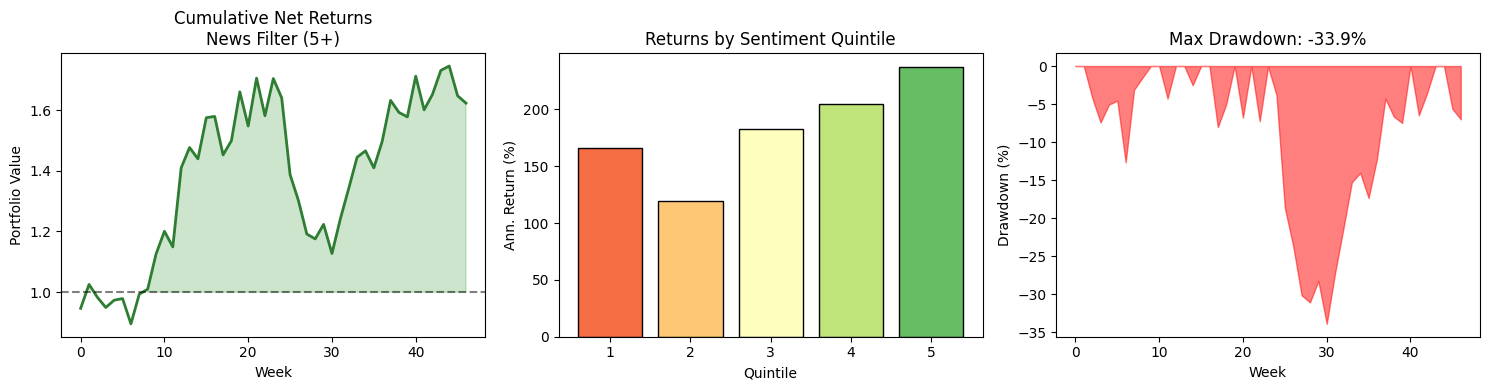

In [55]:
best = results[best_name]
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Cumulative returns
cum_ret = (1 + best['returns']['spread_net'].fillna(0)).cumprod()
axes[0].plot(range(len(cum_ret)), cum_ret.values, color='#2E7D32', linewidth=2)
axes[0].axhline(1, color='black', linestyle='--', alpha=0.5)
axes[0].fill_between(range(len(cum_ret)), 1, cum_ret.values, where=cum_ret.values>=1, color='green', alpha=0.2)
axes[0].set_xlabel('Week'); axes[0].set_ylabel('Portfolio Value'); axes[0].set_title(f'Cumulative Net Returns\n{best_name}')

# Quintile returns
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, 5))
axes[1].bar([1,2,3,4,5], [m*100 for m in best['quintile_means']], color=colors, edgecolor='black')
axes[1].set_xlabel('Quintile'); axes[1].set_ylabel('Ann. Return (%)'); axes[1].set_title('Returns by Sentiment Quintile')
axes[1].axhline(0, color='black', linewidth=0.5)

# Drawdown
roll_max = cum_ret.cummax()
dd = (cum_ret - roll_max) / roll_max
axes[2].fill_between(range(len(dd)), 0, dd.values*100, color='red', alpha=0.5)
axes[2].set_xlabel('Week'); axes[2].set_ylabel('Drawdown (%)'); axes[2].set_title(f'Max Drawdown: {dd.min():.1%}')

plt.tight_layout(); plt.savefig(f'{PROJECT_PATH}/final_strategy.png', dpi=150); plt.show()


ALL STRATEGIES RANKED BY NET SHARPE
✓ Weekly, News Filter (5+)  | Gross: +71.7% | Net: +67.6% | Sharpe: +1.26
✓ Weekly, News Filter (3+)  | Gross: +10.8% | Net: +6.6% | Sharpe: +0.21
✓ Daily, 10d Hold           | Gross: +10.1% | Net: +7.6% | Sharpe: +0.14
✓ Daily, 5d Hold            | Gross: +5.3% | Net: +0.2% | Sharpe: +0.01
✗ Weekly, News Filter (4+)  | Gross: -3.1% | Net: -7.2% | Sharpe: -0.17
✗ Weekly, Baseline (all data) | Gross: -1.6% | Net: -5.8% | Sharpe: -0.53
✗ Daily, 1d Hold            | Gross: +14.8% | Net: -10.4% | Sharpe: -0.60
✗ Weekly, News Filter (6+)  | Gross: -48.2% | Net: -52.4% | Sharpe: -0.79


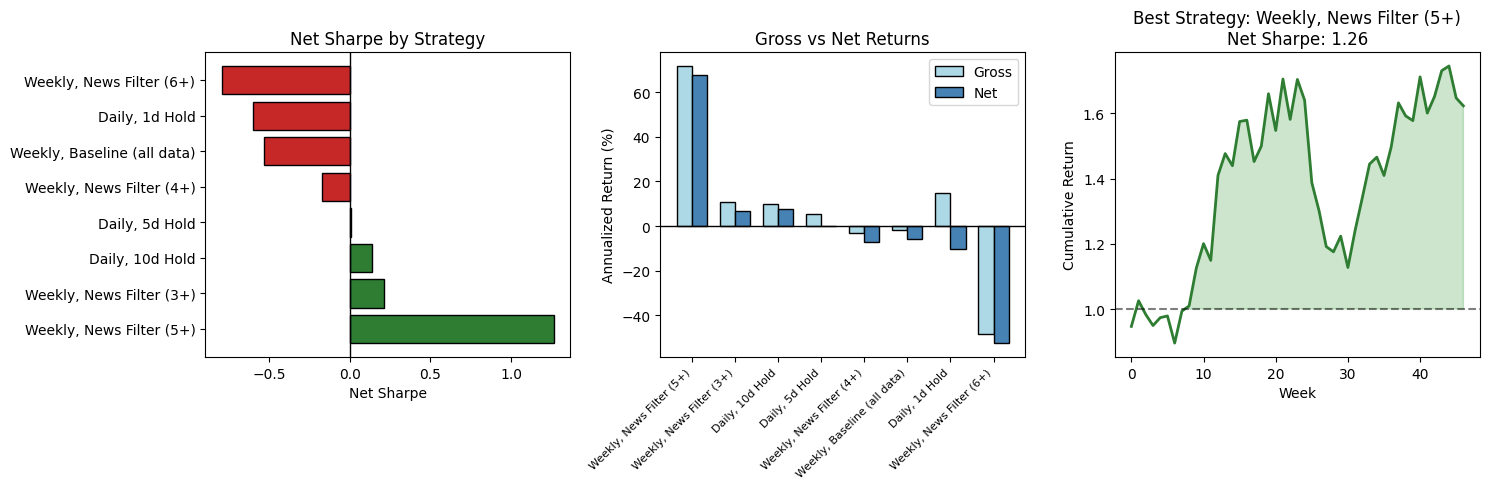


SUMMARY
Profitable strategies: 4/8
Best strategy: Weekly, News Filter (5+) (Sharpe: 1.26, Net: 67.6%)


In [56]:
# ==============================================================================
# COMPREHENSIVE STRATEGY COMPARISON
# ==============================================================================

# 1. Collect all results into one table
all_strategies = []

# Daily holding period results (from Stage 8)
daily_holding = [
    ('Daily, 1d Hold',  0.148, -0.104, -0.60),
    ('Daily, 5d Hold',  0.053,  0.002,  0.01),
    ('Daily, 10d Hold', 0.101,  0.076,  0.14),
]
for name, gross, net, sharpe in daily_holding:
    all_strategies.append({'Strategy': name, 'Gross': gross, 'Net': net, 'Sharpe': sharpe, 'Freq': 'Daily'})

# Weekly results (from Stage 9)
for name, r in results.items():
    all_strategies.append({
        'Strategy': f'Weekly, {name}',
        'Gross': r['gross_return'],
        'Net': r['net_return'],
        'Sharpe': r['sharpe_net'],
        'Freq': 'Weekly'
    })

# Create DataFrame
comp_df = pd.DataFrame(all_strategies).sort_values('Sharpe', ascending=False)

print("=" * 70)
print("ALL STRATEGIES RANKED BY NET SHARPE")
print("=" * 70)
for _, row in comp_df.iterrows():
    status = "✓" if row['Sharpe'] > 0 else "✗"
    print(f"{status} {row['Strategy']:25s} | Gross: {row['Gross']:+.1%} | Net: {row['Net']:+.1%} | Sharpe: {row['Sharpe']:+.2f}")

# 2. Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Net Sharpe comparison
ax = axes[0]
colors = ['#2E7D32' if s > 0 else '#C62828' for s in comp_df['Sharpe']]
ax.barh(range(len(comp_df)), comp_df['Sharpe'], color=colors, edgecolor='black')
ax.set_yticks(range(len(comp_df)))
ax.set_yticklabels(comp_df['Strategy'])
ax.axvline(0, color='black', linewidth=1)
ax.set_xlabel('Net Sharpe')
ax.set_title('Net Sharpe by Strategy')

# Plot 2: Gross vs Net returns
ax = axes[1]
x = range(len(comp_df))
w = 0.35
ax.bar([i - w/2 for i in x], comp_df['Gross'] * 100, w, label='Gross', color='lightblue', edgecolor='black')
ax.bar([i + w/2 for i in x], comp_df['Net'] * 100, w, label='Net', color='steelblue', edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(comp_df['Strategy'], rotation=45, ha='right', fontsize=8)
ax.axhline(0, color='black', linewidth=1)
ax.set_ylabel('Annualized Return (%)')
ax.set_title('Gross vs Net Returns')
ax.legend()

# Plot 3: Best strategy cumulative returns
ax = axes[2]
best_name = comp_df.iloc[0]['Strategy'].replace('Weekly, ', '')
if best_name in results:
    cum_ret = (1 + results[best_name]['returns']['spread_net'].fillna(0)).cumprod()
    ax.plot(range(len(cum_ret)), cum_ret.values, color='#2E7D32', linewidth=2)
    ax.fill_between(range(len(cum_ret)), 1, cum_ret.values, where=cum_ret.values >= 1, color='green', alpha=0.2)
    ax.axhline(1, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Week')
    ax.set_ylabel('Cumulative Return')
    ax.set_title(f'Best Strategy: {comp_df.iloc[0]["Strategy"]}\nNet Sharpe: {comp_df.iloc[0]["Sharpe"]:.2f}')

plt.tight_layout()
plt.savefig(f'{PROJECT_PATH}/strategy_comparison.png', dpi=150)
plt.show()

# 3. Summary
print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
profitable = comp_df[comp_df['Sharpe'] > 0]
print(f"Profitable strategies: {len(profitable)}/{len(comp_df)}")
print(f"Best strategy: {comp_df.iloc[0]['Strategy']} (Sharpe: {comp_df.iloc[0]['Sharpe']:.2f}, Net: {comp_df.iloc[0]['Net']:.1%})")

In [62]:
# ==============================================================================
# LIST ALL SAVED CHECKPOINTS
# ==============================================================================

list_checkpoints()

Available checkpoints in /content/drive/MyDrive/sentiment_project:
  - analyst_ratings_clean.parquet (64.5 MB)
  - analyst_ratings_filtered.parquet (15.8 MB)
  - analyst_ratings_final.parquet (17.3 MB)
  - daily_sentiment.parquet (1.7 MB)
  - data_with_deciles.parquet (11.0 MB)
  - decile_2day_returns.parquet (0.3 MB)
  - long_short_2day_returns.parquet (0.0 MB)
  - long_short_returns.parquet (0.3 MB)
  - long_short_with_drawdown.parquet (0.4 MB)
  - news_filter_optimization_results.parquet (0.0 MB)
  - prices_raw.parquet (6.5 MB)
  - prices_with_multihorizon_returns.parquet (176.7 MB)
  - prices_with_returns.parquet (49.7 MB)
  - sentiment_checkpoint_100000.parquet (5.8 MB)
  - sentiment_checkpoint_120000.parquet (7.0 MB)
  - sentiment_checkpoint_140000.parquet (8.2 MB)
  - sentiment_checkpoint_160000.parquet (9.3 MB)
  - sentiment_checkpoint_180000.parquet (10.4 MB)
  - sentiment_checkpoint_20000.parquet (1.2 MB)
  - sentiment_checkpoint_200000.parquet (11.6 MB)
  - sentiment_checkpo

['analyst_ratings_final.parquet',
 'long_short_with_drawdown.parquet',
 'prices_with_multihorizon_returns.parquet',
 'long_short_2day_returns.parquet',
 'decile_2day_returns.parquet',
 'analyst_ratings_clean.parquet',
 'analyst_ratings_filtered.parquet',
 'sentiment_checkpoint_200000.parquet',
 'sentiment_checkpoint_220000.parquet',
 'sentiment_checkpoint_240000.parquet',
 'sentiment_checkpoint_260000.parquet',
 'sentiment_checkpoint_280000.parquet',
 'sentiment_checkpoint_300000.parquet',
 'sentiment_checkpoint_320000.parquet',
 'sentiment_final.parquet',
 'news_filter_optimization_results.parquet',
 'sentiment_checkpoint_20000.parquet',
 'sentiment_checkpoint_40000.parquet',
 'sentiment_checkpoint_60000.parquet',
 'sentiment_checkpoint_80000.parquet',
 'sentiment_checkpoint_100000.parquet',
 'sentiment_checkpoint_120000.parquet',
 'sentiment_checkpoint_140000.parquet',
 'sentiment_checkpoint_160000.parquet',
 'sentiment_checkpoint_180000.parquet',
 'daily_sentiment.parquet',
 'prices